In [1]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

def sort_indices(array, stu_array):
    device = array.device
    stu_array = stu_array.to(device)
    
    # Compute correlation matrix
    correlation = array @ stu_array.T  # Shape: (K, M)
    K, M = correlation.shape
    
    if K == M:
        # Use Hungarian algorithm for optimal assignment
        cost = -correlation.cpu().numpy()  # Minimization problem
        row_ind, col_ind = linear_sum_assignment(cost)
        new_stu_array = stu_array[col_ind].clone()
    else:
        # Handle M > K: Assign top matches and append the rest
        new_stu_array = []
        assigned = set()
        # Assign best match for each row in array
        for i in range(K):
            idx = torch.argmax(correlation[i]).item()
            new_stu_array.append(stu_array[idx])
            assigned.add(idx)
        # Append remaining rows not matched
        for j in range(M):
            if j not in assigned:
                new_stu_array.append(stu_array[j])
        new_stu_array = torch.stack(new_stu_array)
    
    return new_stu_array


=== Testing Case: Teacher(13x500) vs Student(13x500) ===


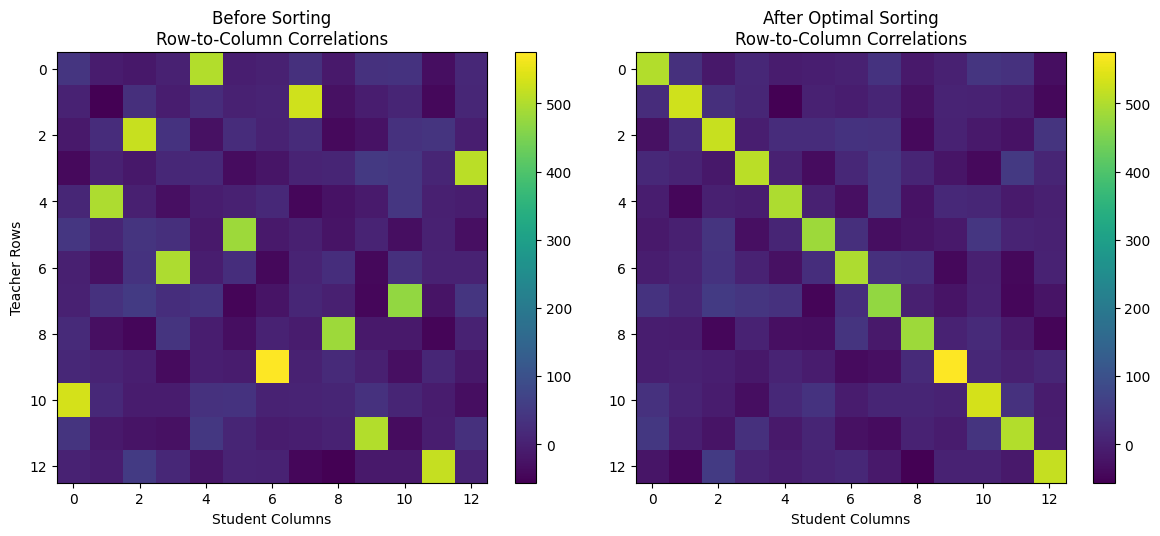

Average diagonal correlation after sorting: 509.5027770996094


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def create_test_data(K, M, N, noise=0.3):
    """Create correlated test data with controlled noise"""
    # Teacher matrix (ground truth patterns)
    teacher = torch.randn(K, N)
    
    # Student matrix (K base patterns + (M-K) random patterns)
    student = torch.cat([
        teacher + noise * torch.randn_like(teacher),  # Corrupted copies
        torch.randn(max(0, M-K), N)                   # Additional random rows
    ])[torch.randperm(M)]  # Shuffle rows
    
    return teacher, student

def plot_comparison(teacher, student_before, student_after):
    """Plot correlation matrices before and after sorting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Compute correlation matrices
    corr_before = teacher @ student_before.T
    corr_after = teacher @ student_after.T
    
    # Plot before sorting
    im1 = ax1.imshow(corr_before.cpu().numpy(), cmap='viridis')
    ax1.set_title('Before Sorting\nRow-to-Column Correlations')
    ax1.set_xlabel('Student Columns')
    ax1.set_ylabel('Teacher Rows')
    fig.colorbar(im1, ax=ax1)
    
    # Plot after sorting
    im2 = ax2.imshow(corr_after.cpu().numpy(), cmap='viridis')
    ax2.set_title('After Optimal Sorting\nRow-to-Column Correlations')
    ax2.set_xlabel('Student Columns')
    fig.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

def test_case(K, M, N):
    """Run one test case with visualization"""
    print(f"\n=== Testing Case: Teacher({K}x{N}) vs Student({M}x{N}) ===")
    
    # Create test data
    teacher, student = create_test_data(K, M, N)
    student_sorted = sort_indices(teacher, student)
    
    # Plot results
    plot_comparison(teacher, student, student_sorted)
    
    # Print correlation scores
    print("Average diagonal correlation after sorting:", 
          torch.diag(teacher @ student_sorted.T).mean().item())

# Test 1: Same dimensions (K = M = 3)
test_case(K=13, M=13, N=500)

# Test 2: Student larger than teacher (K=2, M=4)
#test_case(K=2, M=4, N=5)


=== Testing Case: Teacher(18x700) vs Student(18x700) ===


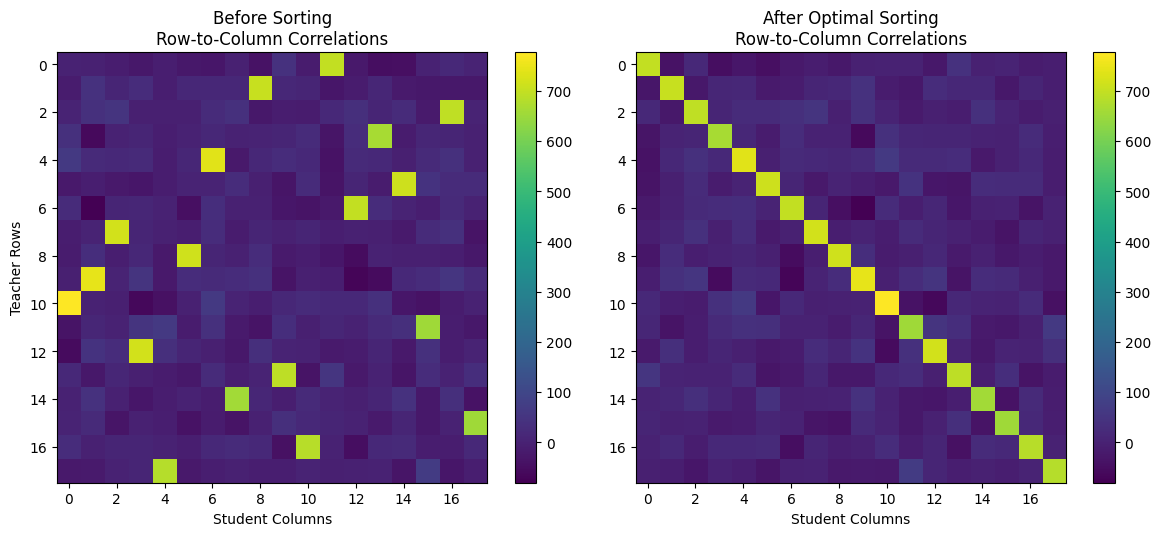

Average diagonal correlation after sorting: 700.65283203125


In [8]:
# Test 1: Same dimensions (K = M = 3)
test_case(K=18, M=18, N=700)